In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns; sns.set('poster')  # noqa
import dash_bio as dashbio
from python.cogtext.datasets.pubmed import PubMedDataLoader
from python.cogtext.similarity_matrix import get_similarity_matrix
from python.cogtext.similarity_matrix import multivariate_normal_kl, multivariate_normal_js
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm; tqdm.pandas()
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions


In [2]:
# load weights, clusters and metadata (takes ~ 20sec)

clusters = pd.read_csv('models/gpt3/abstracts_gpt3ada_clusters.csv.gz', index_col=0)
weights = np.load('models/gpt3/abstracts_gpt3ada_weights.npz')['arr_0']
clusters['weights'] = list(weights)

# load abstracts
pubmed = PubMedDataLoader(preprocessed=False, drop_low_occurred_labels=False).load()
pubmed = pubmed.merge(clusters, on='pmid', how='left')

pubmed.dropna(subset=['cluster'], inplace=True)

tasks = pubmed.query('category.str.contains("Task")')['label'].unique()
constructs = pubmed.query('category.str.contains("Task")')['label'].unique()

print(f'Successfully loaded a list of {len(pubmed)} topic-embeddings.')

Successfully loaded a list of 293014 topic-embeddings.


In [7]:
n_skip = 20
n_top_labels_per_category = 20

popular_labels = (pubmed.groupby(['category','label'])['pmid']
                        .count().sort_values(ascending=False)
                        .groupby('category').head(n_top_labels_per_category)
                        .index.get_level_values('label').to_list())
popular_pubmed = pubmed.query('label in @popular_labels')

X = popular_pubmed.groupby('label')['weights'].apply(lambda x: np.stack(x))

print(f"Popular labels: {', '.join(popular_labels)}")

Popular labels: Attention, WorkingMemory, Planning, Initiation, Sequencing, ExecutiveFunction, Inhibition, Fluency, Reasoning, ProcessingSpeed, EpisodicMemory, Stroop, LongTermMemory, Shifting, ProblemSolving, CogntiveControl, InhibitoryControl, Verbal_fluency_task, ShortTermMemory, Mindfulness, SelectiveAttention, SelfRegulation, TMT_-_Trail_Making_Task, Digit_Span, WCST_-_Wisconsin_Card_Sort_Test, Go_NoGo, NBackTask, FlankerTask, StopSignalTask, IGT_-_Iowa_Gambling_task, PVT_-_Psychomotor_Vigilance_task, ContiniousPerformanceTask, Span_Task, CategoryFluencyTask, Simon_task, PEG_-_Pencil_Tapping_task, Semantic_Fluency_test, TowerOfLondon, DiscountingTask, Sorting_task


In [8]:
# KL model
def nll(X, dist):
  return - tf.reduce_mean(dist.log_prob(X))

@tf.function
def get_loss_and_grads(X_train, dist):
  with tf.GradientTape() as tape:
    tape.watch(dist.trainable_variables)
    loss = nll(X_train, dist)
  grads = tape.gradient(loss, dist.trainable_variables)
  return loss, grads

def fit_multivariate_normal(data, n_epochs=10, batch_size=100):
  dist = tfd.MultivariateNormalDiag(
    loc=tf.Variable(data.mean(axis=0), name='loc'),
    scale_diag=tf.Variable(np.ones(data.shape[1]), name='scale_diag'))

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

  for _ in range(n_epochs):
    # for batch in np.array_split(data, 1 + (data.shape[0] // batch_size)):
    batch = data  # use all the data in each epoch
    loss, grads = get_loss_and_grads(batch, dist)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    # loc_value = dist.loc.value()
  return dist

X_dists = X.progress_apply(fit_multivariate_normal)


100%|██████████| 40/40 [00:39<00:00,  1.00it/s]


In [ ]:
# cache the node-to-node kl distance matrix
js_losses = np.zeros((len(X_dists), len(X_dists)))

for i,lbl_i in tqdm(enumerate(X_dists.index)):
  for j, lbl_j in enumerate(X_dists.index):
    P = X_dists.loc[lbl_i]
    Q = X_dists.loc[lbl_j]
    M = tfd.MultivariateNormalDiag(
      loc=(P.mean() + Q.mean())/2.,
      scale_diag=(P.stddev() + Q.stddev())/2.
    )
    js = .5 * (P.kl_divergence(M) + Q.kl_divergence(M)).numpy()
    # print(X_dists.loc[lbl_i].trainable_variables[1].shape)
    js_losses[i,j] = js

js_losses = pd.DataFrame(js_losses, index=X_dists.index, columns=X_dists.index)
sns.clustermap(js_losses, cmap='viridis', figsize=(25,25))

In [20]:
# store it for future use
js_losses.to_csv('models/gpt3/multivariate_normal_js_losses.csv')

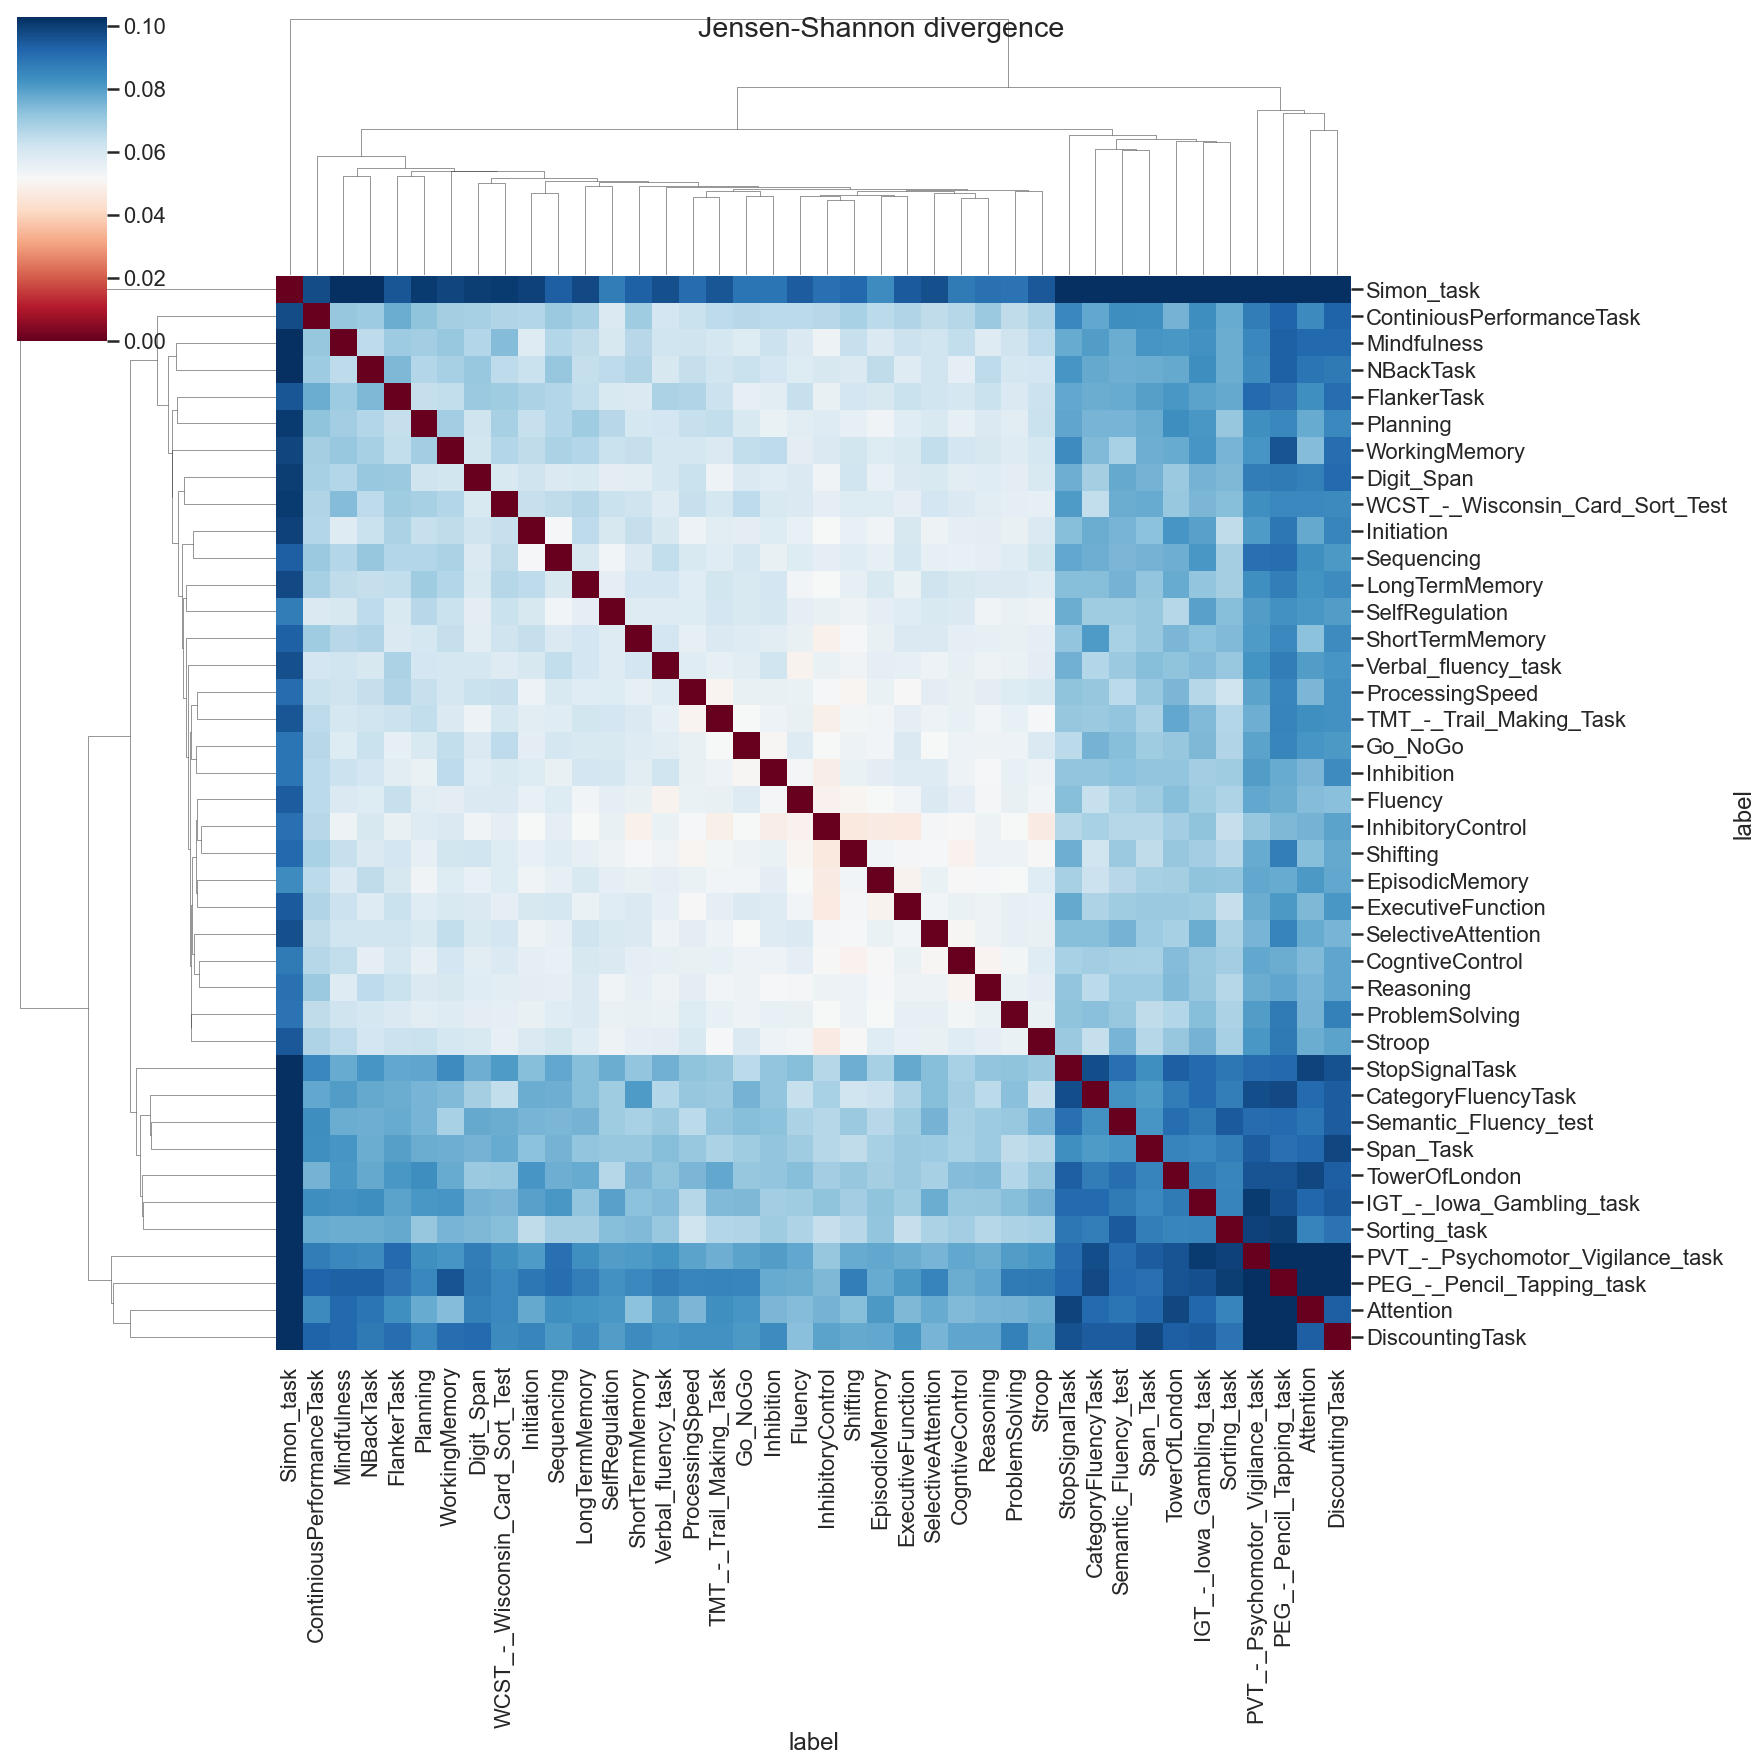

In [19]:
tasks = pubmed.query('category.str.contains("Task")')['label'].unique()
constructs = pubmed.query('category.str.contains("Construct")')['label'].unique()

# losses.drop(columns=constructs, inplace=True)
# losses.drop(index=tasks, inplace=True)

# drop tasks from rows and columns

sns.clustermap(
  js_losses,
  figsize=(25,25),
  cmap='RdBu', robust=True)

plt.suptitle('Jensen-Shannon divergence')
plt.show()


## Constructs

In [21]:
# js_losses = pd.read_csv('models/cogtext/multivariate_normal_js_losses.csv', index_col=0)


js_losses_constructs = js_losses.drop(index=tasks, columns=tasks, errors='ignore')

# sns.set('poster')
# sns.clustermap(
#   js_losses,
#   figsize=(40,42),
#   cmap='RdBu_r', robust=True)

# plt.show()

dashbio.Clustergram(
  data=js_losses_constructs,
  column_labels=js_losses_constructs.columns.to_list(),
  row_labels=js_losses_constructs.index.to_list(),
  cluster='all',
  center_values=True,
  standardize=True,
  height=800,
  width=1000,
  display_ratio=[0.001, 0.001],
  color_map='RdBu_r',
  hidden_labels=['col'],
  row_dist='euclidean',
  col_dist='euclidean',
  # standardize='col'
)

## Tasks

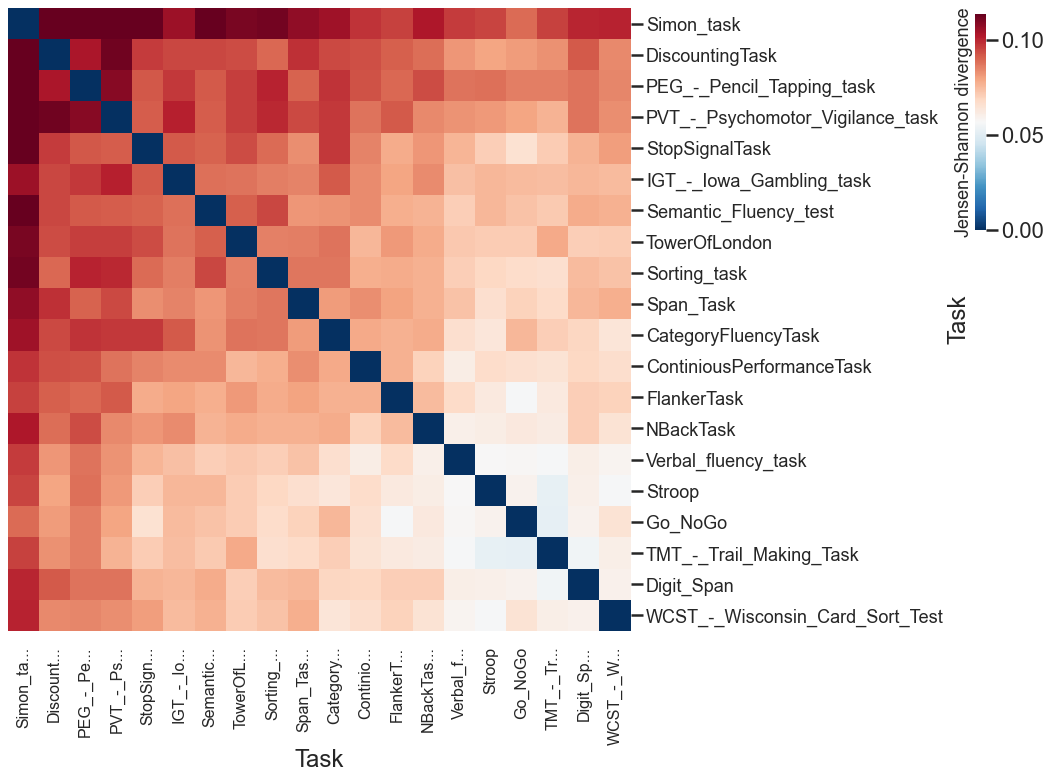

In [142]:
js_losses_tasks = js_losses.drop(index=constructs, columns=constructs, errors='ignore')

g = sns.clustermap(
  js_losses_tasks,
  figsize=(15,15),
  dendrogram_ratio=0.00001,
  cbar_pos=(.92,0.77,.01,.2),
  cmap='RdBu_r', robust=True)

g.ax_heatmap.set(xlabel='Task', ylabel='Task')

ax = g.ax_heatmap
# ax.set_xlabel('xlabel', fontsize=8)
ax.set_xticklabels(
  [f'{l._text[:8]}...' if len(l._text)>8 else l for l in ax.get_xticklabels()], fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

g.ax_cbar.set_title('Jensen-Shannon divergence', fontsize=18, rotation=90, x=-1, y=-.04)

plt.show()